# Hockey Game Prediction: Are hockey teams "streaky"? What Alpha for exponential smoothing variables gives the best result?

Conventional wisdom dictates that Hockey teams' recent performance is the best predictor of current success. This is why we see teams that get "hot" at the end of the season dominate the NHL playoffs rather than teams that were strong all season. This notebook will scrape game data from 2009-present from NHL reference, use simple exponentially smoothed stats as predictors for modeling win probability of the home team, and compare the models that used different smoothing constants (alpha) to determine how "streaky" teams are. The higher the most successful alpha values, the more impact recent games have on current success.

In [1]:
#Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#These functions perform data manipulation tasks on the initial dataset
def homegame(sym):
    if sym == '@':
        nib = 0
    else:
        nib = 1
    return nib

def win(sym):
    if sym == 'W':
        return 1
    else:
        return 0

def game_id_creator(home, date, t1, t2):
    if home == 1:
        home_team = t1
    else:
        home_team = t2
    return str(date) + home_team

#First we will start with a low alpha and go higher
def exp_smoothing(ts, alpha=0.05):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

In [2]:
#Create a dictionary of full team names and abbreviations
#This is needed for joining df's and scraping
teamabbvs = ['WSH', 'STL', 'BOS', 'PIT', 'NYI', 'TBL', 'COL', 
             'DAL', 'TOR', 'ARI', 'CGY', 'VAN', 'CBJ', 'PHI',
             'CAR', 'VEG', 'EDM', 'FLA', 'WPG', 'BUF', 'NYR',
             'CHI', 'MTL', 'NSH', 'MIN', 'SJS', 'ANA', 'NJD',
             'LAK', 'OTT', 'DET', 'PHO', 'ATL']

teamnames = ['Washington Capitals', 'St. Louis Blues', 'Boston Bruins', 
            'Pittsburgh Penguins', 'New York Islanders', 'Tampa Bay Lightning', 
            'Colorado Avalanche', 'Dallas Stars', 'Toronto Maple Leafs', 
            'Arizona Coyotes', 'Calgary Flames', 'Vancouver Canucks', 
            'Columbus Blue Jackets', 'Philadelphia Flyers',
            'Carolina Hurricanes', 'Vegas Golden Knights', 
            'Edmonton Oilers', 'Florida Panthers', 'Winnipeg Jets', 
            'Buffalo Sabres', 'New York Rangers','Chicago Blackhawks',
            'Montreal Canadiens', 'Nashville Predators', 'Minnesota Wild', 
            'San Jose Sharks','Anaheim Ducks', 'New Jersey Devils',
            'Los Angeles Kings', 'Ottawa Senators', 'Detroit Red Wings', 
            'Phoenix Coyotes', 'Atlanta Thrashers']
teamslistdf = pd.DataFrame({'Abbv':teamabbvs, 'TeamName':teamnames})

In [3]:
#Scrapes NHL Reference for data back from 2009
def hockey(team):
    df = pd.DataFrame()
    for i in range(2009, 2020):
        try:
            link = 'https://www.hockey-reference.com/teams/' + team +'/' + str(i) +'_gamelog.html'
            pdata = pd.read_html(link, header=[1])
            data = pdata[0]
            data = data.where(data.Date != 'Date')
            data['Date'] = pd.to_datetime(data['Date'])
            data.dropna(how = 'all', inplace = True)
            data['HomeTeamAbbv'] = team
            data = data.merge(teamslistdf, how ='left', left_on = 'Opponent', right_on = 'TeamName')
            data.rename(columns={'Unnamed: 2': 'HA', 'Unnamed: 6': 'WL'}, inplace = True)
            data['HA'] = data['HA'].apply(homegame)
            data['Game_ID'] = data.apply(lambda x: game_id_creator(x['HA'], x['Date'], x['HomeTeamAbbv'], x['Abbv']), axis=1)
            data['WL'] = data['WL'].apply(win)
            data[['S', 'PIM', 'PPG', 'PPO', 'SHG', 'GF', 'GA', 'CF', 'CA', 'FF', 'FA', 'FOW', 'FOL', 'oZS%', 'PDO']] = data[['S', 'PIM', 'PPG', 'PPO', 'SHG', 'GF', 'GA', 'CF', 'CA', 'FF', 'FA', 'FOW', 'FOL', 'oZS%', 'PDO']].apply(pd.to_numeric, errors='coerce')
            data['S_ravg'] = exp_smoothing(data['S'])
            data['WP_roll'] = exp_smoothing(data['WL'])
            data['GF_ravg'] = exp_smoothing(data['GF'])
            data['GA_ravg'] = exp_smoothing(data['GA'])
            data['PIM_ravg'] = exp_smoothing(data['PIM'])
            data['PPG_ravg'] = exp_smoothing(data['PPG'])
            data['PPO_ravg'] = exp_smoothing(data['PPO'])
            data['SHG_ravg'] = exp_smoothing(data['SHG'])
            data['CF_ravg'] = exp_smoothing(data['CF'])
            data['CA_ravg'] = exp_smoothing(data['CA'])
            data['CP_ravg'] = data['CF'].rolling(10).sum()/(data['CA'].rolling(10).sum()+data['CF'].rolling(10).sum())
            data['CP_ravg'] = data.CP_ravg.shift(1)
            data['FF_ravg'] = exp_smoothing(data['FF'])
            data['FA_ravg'] = exp_smoothing(data['FA'])
            data['FP_ravg'] = data['FF'].rolling(10).sum()/(data['FA'].rolling(10).sum()+data['FF'].rolling(10).sum())
            data['FP_ravg'] = data.FP_ravg.shift(1)
            data['FOW_ravg'] = exp_smoothing(data['FOW'])
            data['FOL_ravg'] = exp_smoothing(data['FOL'])
            data['FOP_ravg'] = data['FOW'].rolling(10).sum()/(data['FOW'].rolling(10).sum()+data['FOL'].rolling(10).sum())
            data['FOP_ravg'] = data.FOP_ravg.shift(1)
            data['oZS%_ravg'] = exp_smoothing(data['oZS%'])
            data['PDO_ravg'] = exp_smoothing(data['PDO'])

            data['Date_Int'] = pd.to_numeric(data['Date'])
            data['G_diff_ravg'] = data['GF_ravg'] - data['GA_ravg']   
            df = df.append(data)
        except:
            pass
    hockey_df = df
    return hockey_df

#This function does the scraping for every team
def full_hockey():
    df = pd.DataFrame()
    for i in teamabbvs:
        data = hockey(i)
        df = df.append(data)
    return df

In [4]:
#Call function that scrapes all games
initial_set = full_hockey()

In [5]:
#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

In [6]:
#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

In [7]:
X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

0.5645161290322581


C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

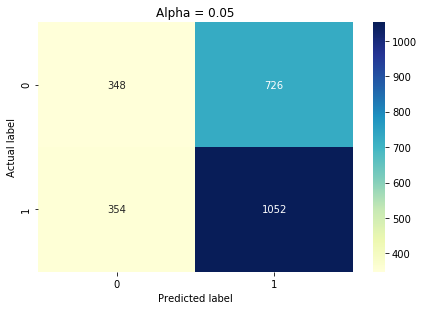

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
from sklearn.linear_model import LogisticRegression
model_05 = LogisticRegression()
model_05.fit(X_train,y_train)
y_pred=model_05.predict(X_test)
from sklearn import metrics
cnf_matrix_05 = metrics.confusion_matrix(y_test, y_pred)
acc_05 = metrics.accuracy_score(y_test, y_pred)
print(acc_05)
sns.heatmap(pd.DataFrame(cnf_matrix_05), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Alpha = 0.05', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## The alpha of 0.05 gave us an accuracy of 56.45%. Not bad, let's see if our features were significant.

In [9]:
from sklearn.feature_selection import f_regression
pvals = f_regression(X_train, y_train, center=True)
pvals = pvals[1]
dataset = pd.DataFrame({'variable': X.columns, 'pvals': pvals}, columns=['variable', 'pvals'])
dataset

,variable,pvals
0,Home_S_ravg,2.895260e-08
1,Home_WP_roll,2.745716e-09
2,Home_GF_ravg,1.734137e-05
3,Home_GA_ravg,6.029847e-07
4,Home_PIM_ravg,7.594007e-01
5,Home_PPG_ravg,1.847768e-03
6,Home_SHG_ravg,4.311951e-03
7,Home_CF_ravg,1.219232e-04
8,Home_CA_ravg,6.291232e-12
9,Home_CP_ravg,5.010414e-17


## Looks like all of our features are statistically significant. Wooho!

0.5657258064516129


C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

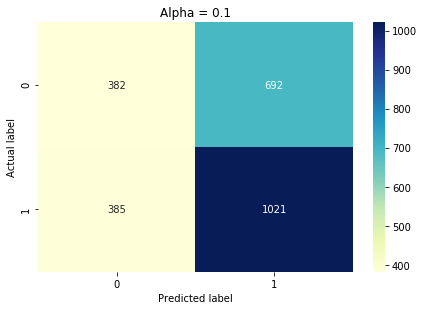

In [10]:
#Now we will set alpha to 0.1 and repeat the process
def exp_smoothing(ts, alpha=0.1):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

initial_set = full_hockey()

#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
model_1 = LogisticRegression()
model_1.fit(X_train,y_train)
y_pred=model_1.predict(X_test)
cnf_matrix_1 = metrics.confusion_matrix(y_test, y_pred)
acc_1 = metrics.accuracy_score(y_test, y_pred)
print(acc_1)
sns.heatmap(pd.DataFrame(cnf_matrix_1), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Alpha = 0.1', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## The alpha of 0.1 worked a bit better than 0.05. Let's try 0.2.

0.5604838709677419


C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

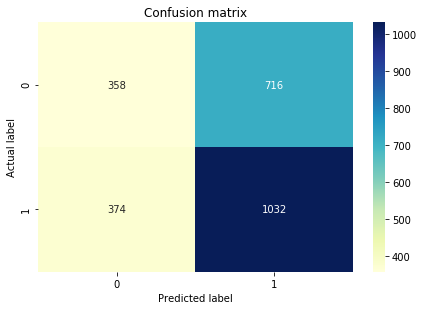

In [11]:
#Now we will set alpha to 0.2 and repeat the process
def exp_smoothing(ts, alpha=0.2):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

initial_set = full_hockey()

#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
model_2 = LogisticRegression()
model_2.fit(X_train,y_train)
y_pred=model_2.predict(X_test)
cnf_matrix_2 = metrics.confusion_matrix(y_test, y_pred)
acc_2 = metrics.accuracy_score(y_test, y_pred)
print(acc_2)
sns.heatmap(pd.DataFrame(cnf_matrix_2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Alpha = 0.2', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 0.2 performed even worse than 0.05. Let's try 0.075.

0.5653225806451613


C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

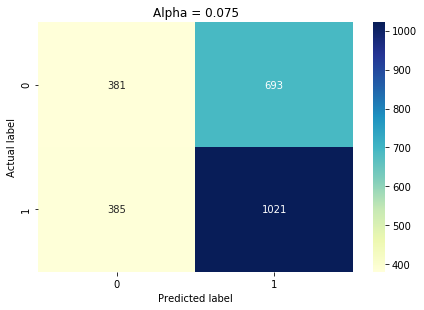

In [12]:
#Now we will set alpha to 0.075 and repeat the process
def exp_smoothing(ts, alpha=0.075):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

initial_set = full_hockey()

#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
model_075 = LogisticRegression()
model_075.fit(X_train,y_train)
y_pred=model_075.predict(X_test)
cnf_matrix_075 = metrics.confusion_matrix(y_test, y_pred)
acc_075 = metrics.accuracy_score(y_test, y_pred)
print(acc_075)
sns.heatmap(pd.DataFrame(cnf_matrix_075), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Alpha = 0.075', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 0.075 was slightly less accurate than 0.1.

0.5600806451612903


C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

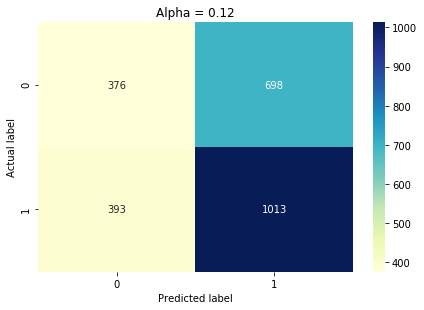

In [13]:
#Now we will set alpha to 0.12 and repeat the process
def exp_smoothing(ts, alpha=0.12):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

initial_set = full_hockey()

#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
model_12 = LogisticRegression()
model_12.fit(X_train,y_train)
y_pred=model_12.predict(X_test)
cnf_matrix_12 = metrics.confusion_matrix(y_test, y_pred)
acc_12 = metrics.accuracy_score(y_test, y_pred)
print(acc_12)
sns.heatmap(pd.DataFrame(cnf_matrix_12), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Alpha = 0.12', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Of the alpha levels tested, 0.1 had the best accuracy. Just for fun, let's use XGBoost to see how much accuracy we can squeeze out of this model.

In [14]:
def exp_smoothing(ts, alpha=0.1):
    
    ts = ts.copy()

    try:
        ts = ts.tolist()
    except:
        pass
    
    f = [np.nan]
    f.append(ts[0])
     
    for t in range(1,len(ts)-1):
        f.append((1-alpha)*f[-1]+alpha*ts[t])  
    return f

initial_set = full_hockey()

#Joins with opponent data
#Home Teams Only
home_games = initial_set.where(initial_set.HA == 1)
#Drop missing data
home_games.dropna(how = 'all', inplace = True)
#Get rid of opponent columns
home_games.drop(home_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
#Name home columns to make easier when joining with away df
home_games.rename(columns={'WL': 'home_win', 'S_ravg': 'Home_S_ravg', 'WP_roll': 'Home_WP_roll',
                          'GF_ravg': 'Home_GF_ravg','GA_ravg': 'Home_GA_ravg', 
                          'PIM_ravg': 'Home_PIM_ravg', 'PPG_ravg': 'Home_PPG_ravg',
                          'PPO_ravg': 'Home_PPO_ravg', 'SHG_ravg': 'Home_SHG_ravg',
                          'CF_ravg': 'Home_CF_ravg','CA_ravg': 'Home_CA_ravg',
                          'CP_ravg': 'Home_CP_ravg', 'FF_ravg': 'Home_FF_ravg',
                          'FA_ravg': 'Home_FA_ravg', 'FP_ravg': 'Home_FP_ravg',
                          'FOW_ravg': 'Home_FOW_ravg','FOL_ravg': 'Home_FOL_ravg',
                          'FOP_ravg': 'Home_FOP_ravg','oZS%_ravg': 'Home_oZS%_ravg',
                          'PDO_ravg': 'Home_PDO_ravg', 'G_diff_ravg':'Home_G_diff_ravg'}, inplace = True)
#Repeat steps for away teams
away_games = initial_set.where(initial_set.HA == 0)
away_games.dropna(how = 'all', inplace = True)
away_games.drop(away_games.columns[[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34, 42]], axis = 1, inplace = True)
away_games.rename(columns={'WL': 'away_win', 'S_ravg': 'Away_S_ravg', 'WP_roll': 'Away_WP_roll',
                          'GF_ravg': 'Away_GF_ravg','GA_ravg': 'Away_GA_ravg', 
                          'PIM_ravg': 'Away_PIM_ravg', 'PPG_ravg': 'Away_PPG_ravg',
                          'PPO_ravg': 'Away_PPO_ravg', 'SHG_ravg': 'Away_SHG_ravg',
                          'CF_ravg': 'Away_CF_ravg','CA_ravg': 'Away_CA_ravg',
                          'CP_ravg': 'Away_CP_ravg', 'FF_ravg': 'Away_FF_ravg',
                          'FA_ravg': 'Away_FA_ravg', 'FP_ravg': 'Away_FP_ravg',
                          'FOW_ravg': 'Away_FOW_ravg','FOL_ravg': 'Away_FOL_ravg',
                          'FOP_ravg': 'Away_FOP_ravg','oZS%_ravg': 'Away_oZS%_ravg',
                          'PDO_ravg': 'Away_PDO_ravg', 'G_diff_ravg':'Away_G_diff_ravg'}, inplace = True)
#Merge sets with previously created game ID
full_set = home_games.merge(away_games, how = 'left', on = 'Game_ID')
full_set.dropna(how = 'any', inplace = True)

#Feature engineer for advantages rather than raw stats
full_set['S_ravg_diff'] = full_set['Home_S_ravg'] - full_set['Away_S_ravg']
full_set['WP_diff'] = full_set['Home_WP_roll'] - full_set['Away_WP_roll']
full_set['GF_diff'] = full_set['Home_GF_ravg'] - full_set['Away_GF_ravg']
full_set['GA_diff'] = full_set['Home_GA_ravg'] - full_set['Away_GA_ravg']
full_set['PIM_diff'] = full_set['Home_PIM_ravg'] - full_set['Away_PIM_ravg']
full_set['PPG_diff'] = full_set['Home_PPG_ravg'] - full_set['Away_PPG_ravg']
full_set['SHG_diff'] = full_set['Home_SHG_ravg'] - full_set['Away_SHG_ravg']
full_set['CF_diff'] = full_set['Home_CF_ravg'] - full_set['Away_CF_ravg']
full_set['CA_diff'] = full_set['Home_CA_ravg'] - full_set['Away_CA_ravg']
full_set['CP_diff'] = full_set['Home_CP_ravg'] - full_set['Away_CP_ravg']
full_set['FF_diff'] = full_set['Home_FF_ravg'] - full_set['Away_FF_ravg']
full_set['FA_diff'] = full_set['Home_FA_ravg'] - full_set['Away_FA_ravg']
full_set['FP_diff'] = full_set['Home_FP_ravg'] - full_set['Away_FP_ravg']
full_set['FOW_diff'] = full_set['Home_FOW_ravg'] - full_set['Away_FOW_ravg']
full_set['FOL_diff'] = full_set['Home_FOL_ravg'] - full_set['Away_FOL_ravg']
full_set['FOP_diff'] = full_set['Home_FOP_ravg'] - full_set['Away_FOP_ravg']
full_set['oZS%_diff'] = full_set['Home_oZS%_ravg'] - full_set['Away_oZS%_ravg']
full_set['PDO_diff'] = full_set['Home_PDO_ravg'] - full_set['Away_PDO_ravg']
full_set['G_diff'] = full_set['Home_G_diff_ravg'] - full_set['Away_G_diff_ravg']

X = full_set[['Home_S_ravg', 'Home_WP_roll',
                          'Home_GF_ravg','Home_GA_ravg', 
                          'Home_PIM_ravg','Home_PPG_ravg',
                          'Home_SHG_ravg',
                          'Home_CF_ravg','Home_CA_ravg',
                          'Home_CP_ravg','Home_FF_ravg',
                          'Home_FA_ravg', 'Home_FP_ravg',
                          'Home_FOW_ravg','Home_FOL_ravg',
                          'Home_FOP_ravg','Home_oZS%_ravg',
                          'Home_PDO_ravg', 
                          'Home_G_diff_ravg',
                          'Away_S_ravg', 'Away_WP_roll',
                          'Away_GF_ravg','Away_GA_ravg', 
                          'Away_PIM_ravg', 'Away_PPG_ravg',
                          'Away_SHG_ravg',
                          'Away_CF_ravg','Away_CA_ravg',
                          'Away_CP_ravg', 'Away_FF_ravg',
                          'Away_FA_ravg', 'Away_FP_ravg',
                          'Away_FOW_ravg','Away_FOL_ravg',
                          'Away_FOP_ravg','Away_oZS%_ravg', 'Away_G_diff_ravg',
                          'Away_PDO_ravg', 
                          
                          'S_ravg_diff',
                          'WP_diff', 'GF_diff', 'GA_diff',
                          'PIM_diff', 'PPG_diff',
                          'SHG_diff',
                          'CF_diff', 'CA_diff',
                          'CP_diff', 'FF_diff',
                          'FA_diff', 'FP_diff',
                          'FOW_diff', 'FOL_diff',
                          'FOP_diff', 'oZS%_diff'
                          ,'G_diff'
                          ]]
y = full_set['home_win']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

#XGB
from xgboost import XGBClassifier
learning_rates = [0.05,0.1,0.2]
estimators = [30,100,500]
depths = [3,5,7]
results = {}
for lr in learning_rates:
    for n in estimators:
        for depth in depths:
            xg = XGBClassifier(learning_rate = lr, n_estimators = n, max_depth = depth)
            xg.fit(X_train, y_train)
            y_pred=xg.predict(X_test)
            results.update({("{}-lr-{}-est-{}-depth".format(lr,n,depth)):
                           metrics.accuracy_score(y_test, y_pred)})

results


{'0.05-lr-30-est-3-depth': 0.569758064516129,
 '0.05-lr-30-est-5-depth': 0.5512096774193549,
 '0.05-lr-30-est-7-depth': 0.5459677419354839,
 '0.05-lr-100-est-3-depth': 0.5645161290322581,
 '0.05-lr-100-est-5-depth': 0.5491935483870968,
 '0.05-lr-100-est-7-depth': 0.5395161290322581,
 '0.05-lr-500-est-3-depth': 0.5435483870967742,
 '0.05-lr-500-est-5-depth': 0.5383064516129032,
 '0.05-lr-500-est-7-depth': 0.5310483870967742,
 '0.1-lr-30-est-3-depth': 0.5633064516129033,
 '0.1-lr-30-est-5-depth': 0.5568548387096774,
 '0.1-lr-30-est-7-depth': 0.5479838709677419,
 '0.1-lr-100-est-3-depth': 0.5620967741935484,
 '0.1-lr-100-est-5-depth': 0.5576612903225806,
 '0.1-lr-100-est-7-depth': 0.5439516129032258,
 '0.1-lr-500-est-3-depth': 0.55,
 '0.1-lr-500-est-5-depth': 0.5370967741935484,
 '0.1-lr-500-est-7-depth': 0.5435483870967742,
 '0.2-lr-30-est-3-depth': 0.5596774193548387,
 '0.2-lr-30-est-5-depth': 0.5479838709677419,
 '0.2-lr-30-est-7-depth': 0.5423387096774194,
 '0.2-lr-100-est-3-depth': 0

## While it would not be wise to use these models to bet, we were able to get nearly 2% higher accuracy over a naive prediction using only simple expnentially smoothed variables. However, an alpha of 0.1 is not very high all things considered. Perhaps hockey teams are not quite as streaky as one might believe.